In [329]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import visualize as vis
import danframe as dan
import kontin as con
import lines as lin
import numpy as np
import astropy.io.fits as fts
import binner as bn

pl.rcParams["figure.figsize"] = (10,6) # Bigger figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data series and line definitions
This loads the entire sS1 run, sorts according to the continuum contrasts and then saves the top twelve frames. The continum is fitted to points selected automatically with the "top 5%" algorithm. 

The individual rows of the spectra are then divided by the continuum that has been fit to points selected by the algorith, normalizing them.

In [330]:
s6405_t5p = dan.frameseries("data/6405_aS1","top 5%")
s6405_seg = dan.frameseries("data/6405_aS1","segments")

# Load continuum contrast 
cont, =  fts.open("data/6405_aS1__concont.fits")
#From plot decide to keep top 10 scoring frames
# A= cont.data; A.sort(); pl.plot(A,'o'); pl.show() 

# Group cont with order value, sort by cont in decreasing order, then save only the top ten frames
qual = [(x,i) for i,x in enumerate(cont.data)] ; qual.sort(key=lambda x: x[0],reverse=True)
s6405_t5p.frames = [s6405_t5p.frames[x[1]] for x in qual[:12]]
s6405_t5p.normalize()
s6405_seg.normalize()

#### Loading the line definitions
The lines are created from line windows have been made semi-automatically, by indicating a rough area on the reference spectra where the line is found, and then trimming the window down to size by cutting off at inflection points of the spectrum. They could probably stand a bit of revision revisited as I think they where created without using the linear continum correction the dataframes get.

In [368]:
lins = lin.make_splines_from_wins(s6405_t5p,s6405_t5p.pkwindows)
CN   = lins[0]
FeI  = lins[1]
SiFe = lins[2]
myst = lins[3]
CNq  = lins[4]

#### Plotting the spectral interval and marking the line windows

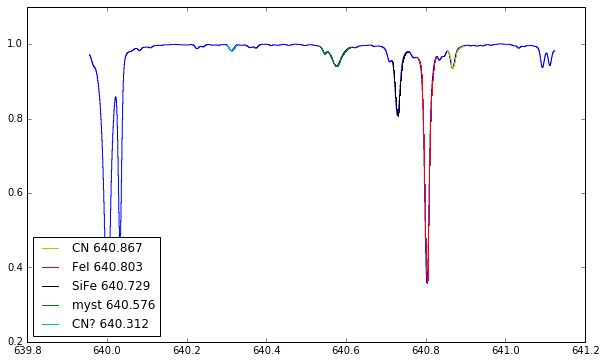

In [180]:
pl.rcParams["figure.figsize"] = (10,6)
pl.step(s6405_t5p.lmbd,s6405_t5p.ref)
pl.step(s6405_t5p.lmbd[CN.idx],s6405_t5p.ref[CN.idx],'y',label="CN "+CN.name)
pl.step(s6405_t5p.lmbd[FeI.idx],s6405_t5p.ref[FeI.idx],'r',label="FeI "+FeI.name)
pl.step(s6405_t5p.lmbd[SiFe.idx],s6405_t5p.ref[SiFe.idx],'k',label="SiFe "+SiFe.name)
pl.step(s6405_t5p.lmbd[myst.idx],s6405_t5p.ref[myst.idx],'g',label="myst "+myst.name)
pl.step(s6405_t5p.lmbd[CNq.idx],s6405_t5p.ref[CNq.idx],'c',label="CN? "+CNq.name)
pl.legend(loc="lower left")
pl.show()

## Fitting the line shape
The line is approximated with a cubic regression spline using 9 equidistant knots. The nuber of knots is the only free parameter in an otherwise non-parametric fit, with higher numbers give smaller residuals but risks overfitting and giving undue weight to random variance. 

The number of knots is here chosen arbitrarily, though in practice the number does not seem to be very important for the size of the residual.

### Measuring the line shape
Having performed a fit, the result is a $\textrm{C}^1$ function that is evaluated on a wavelenght grid with a spacing of $2\times 10^{-4}$ Å. The line bottom is them simply the minimum value the function takes in the interval, and the line center the wavelenght of the minimum.

The *line height* is then defined as 
$$
l_h = 1 - l_{min}
$$
where $l_{min}$ is relative line intensity at line bottom. Using this I calculate the line heigh at one third, one half, and two thirds the line height using
$$
l_{1/3} = \frac{1+2 l_h}{3} \\
l_{1/2} = \frac{1+l_h}{2} \\
l_{2/3} = \frac{2+l_h}{3} \\
$$

Selecting the ends of the interval on wich the function is below each of these relative intensities then in principle gives the width of the line at these intensities. However, for the unknown line at half maximum the blended line sometimes reaches deep enough that it creates two intervals, which is fixed by detecting the multiplicity of intervals and then selecting the second of the intervals as the one to base the measure on.

For the full with of 2/3s of the maximum the story is even more complicated, but it is left unmitigated as of now, both because it was hard to fix, and because the complication is based on differences in line profile that might be interesting to investigate how they correlate with other quantities.

The line assymetry for each line height is simply the difference between the average wavelenght of the line edges and the line center.

In [333]:
#Helpful constants
bot  = 0; vel  = 1; fwhm = 2; as12 = 3; fw13 = 4; as13 = 5; fw23 = 6; as23 = 7; err  = 8; ew   = 9; cont  = 10;

mesFeI   = FeI.measure(s6405_t5p)
mesSiFe  = SiFe.measure(s6405_t5p)
mesmyst  = myst.measure(s6405_t5p)
mesCN    = CN.measure(s6405_t5p)
mesCNq   = CNq.measure(s6405_t5p)

## Equivalent width
The equivalent width of a spectral line in a discreetly sampled spectrum is given by
$$
\textrm{EW} = \Delta \lambda \sum_i \frac{I_C - I_i}{I_C}
$$
where $\Delta \lambda$ a constant wavelenght bin, $I_C$ the continuum level, and $I_i$ the intensity in bin $i$. Since the spectra are expressed in intensity relative the continiuum we have $I_C = 1$.Further, the wavelenght bins given by the calibration are not uniform so the EW becomes
$$
\textrm{EW} =  \sum_i \Delta \lambda_i \left(1 - I_i\right)
$$
This has been calculated and is presented as the equivalent width below.
\* To be described later

### FeI line

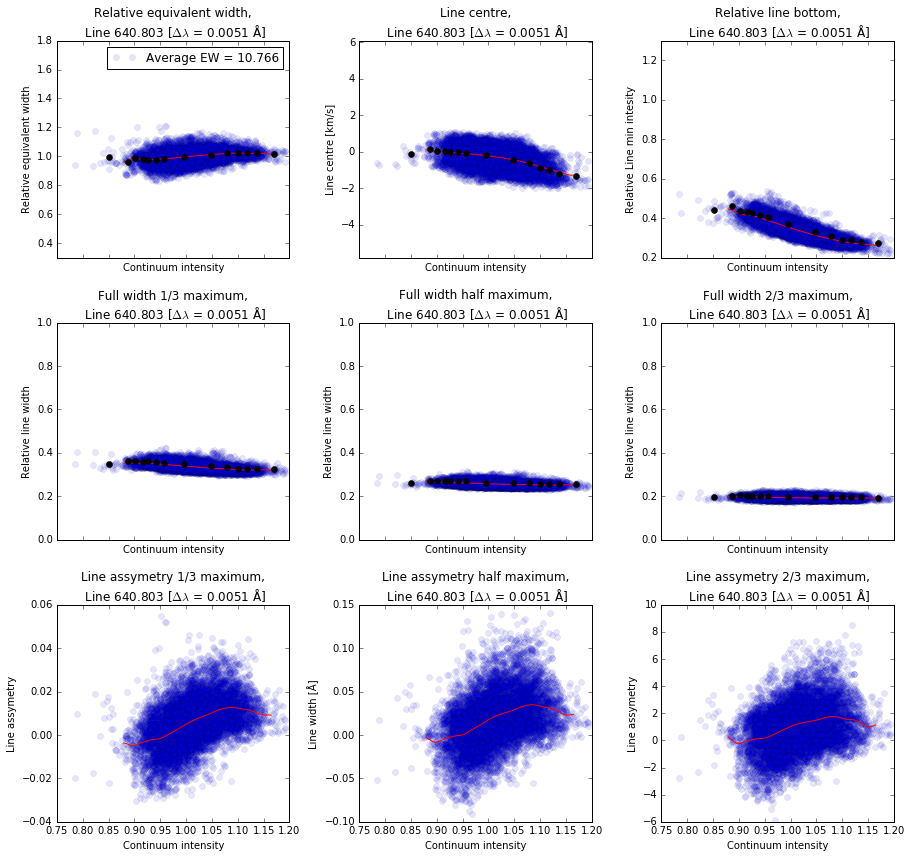

In [413]:
pl.rcParams["figure.figsize"] = (15,14)
#binFeI = bn.binspec(s6405_t5p,mesFeI[:,cont],mesFeI[:,cont],method="blocks")
#mesFeIbin = FeI.measure_on_block(s6405_t5p,binFeI.binned[:,FeI.idx],binFeI.con)

vis.spline_linemap(mesFeI,FeI,mesbin=mesFeIbin)

### The Unknown line

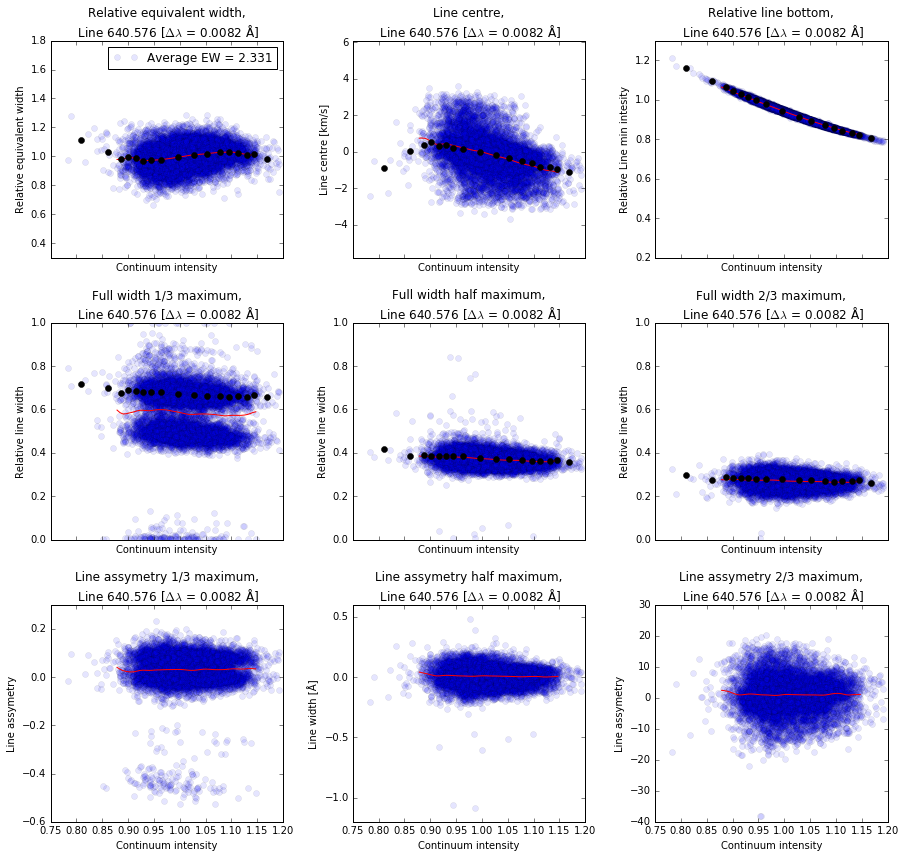

In [414]:
pl.rcParams["figure.figsize"] = (15,14)
#binMyst = bn.binspec(s6405_t5p,mesmyst[:,cont],mesmyst[:,cont],method="blocks")
#mesMystbin = myst.measure_on_block(s6405_t5p,binMyst.binned[:,myst.idx],binMyst.con)

vis.spline_linemap(mesmyst,myst,mesbin=mesMystbin)

True: 4566, False: 5010


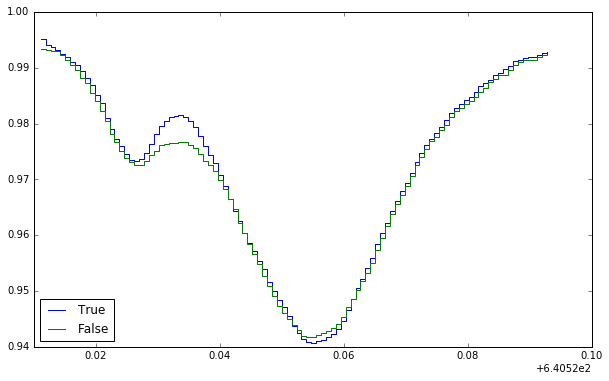

In [415]:
pl.rcParams["figure.figsize"] = (10,6)
MystSplits = bn.binspec(s6405_t5p,mesmyst[:,cont], (mesmyst[:,fw13]/myst.width < 0.6) )
print("True: {}, False: {}".format(MystSplits.counts[0],MystSplits.counts[1]))
pl.step(s6405_t5p.lmbd[myst.idx],MystSplits.binned[0,myst.idx],label="True")
pl.step(s6405_t5p.lmbd[myst.idx],MystSplits.binned[1,myst.idx],label="False")
pl.legend(loc="best")

### Si + Fe line

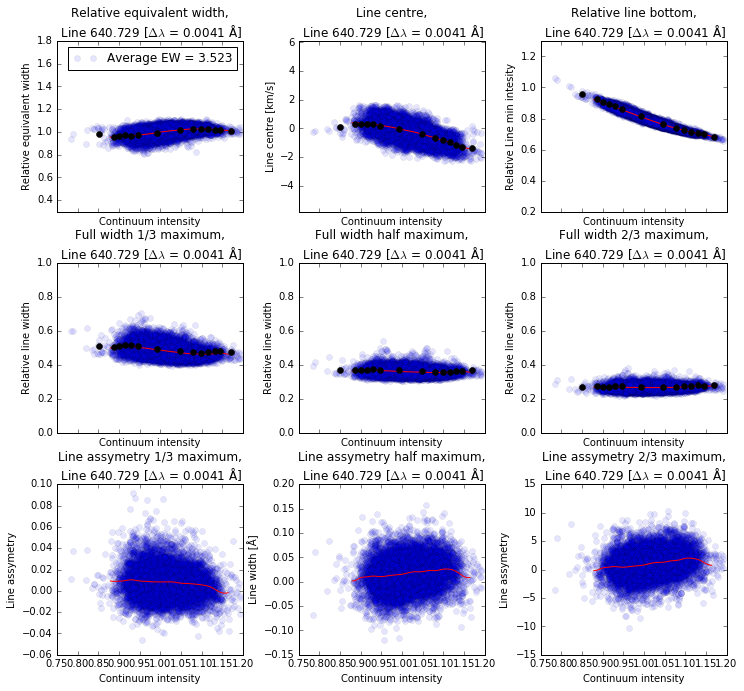

In [416]:
pl.rcParams["figure.figsize"] = (12,11)
#binSiFe = bn.binspec(s6405_t5p,mesSiFe[:,cont],mesSiFe[:,cont],method="blocks")
#mesSiFebin = SiFe.measure_on_block(s6405_t5p,binSiFe.binned[:,SiFe.idx],binSiFe.con)
vis.spline_linemap(mesSiFe,SiFe,mesbin=mesSiFebin)

### CN line 

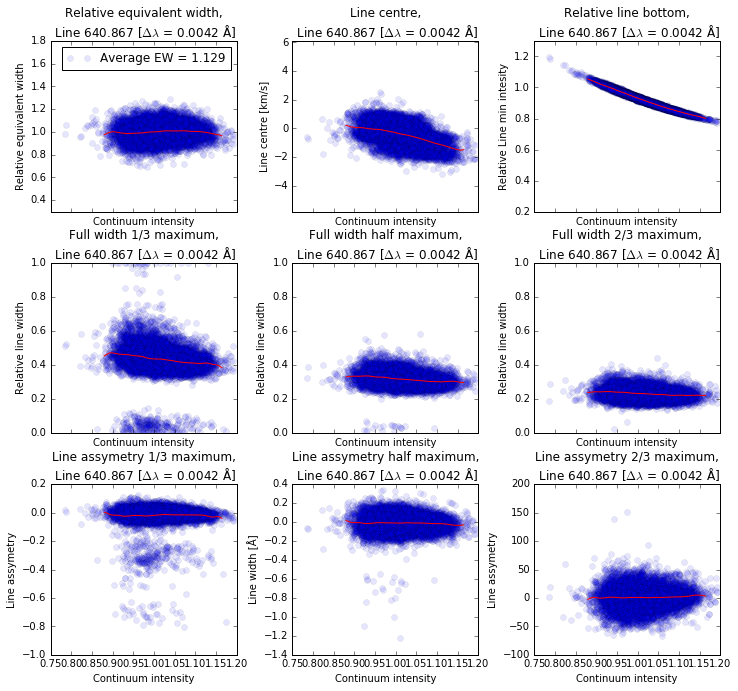

In [417]:
vis.spline_linemap(mesCN,CN)

True: 39, False: 9537


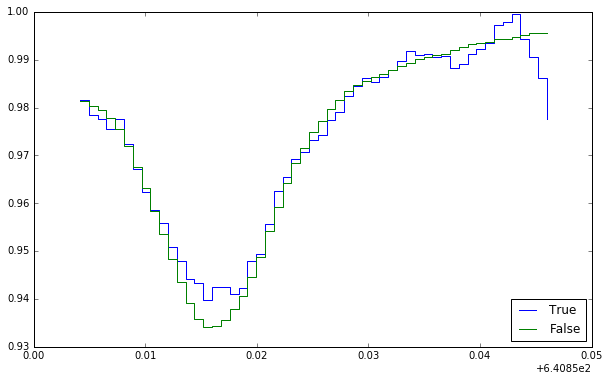

In [418]:
pl.rcParams["figure.figsize"] = (10,6)
CNSplits = bn.binspec(s6405_t5p,mesCN[:,cont], (mesCN[:,as13]/mesCN[:,as13].mean() > 30) )
print("True: {}, False: {}".format(CNSplits.counts[0],CNSplits.counts[1]))
pl.step(s6405_t5p.lmbd[CN.idx],CNSplits.binned[0,CN.idx],label="True")
pl.step(s6405_t5p.lmbd[CN.idx],CNSplits.binned[1,CN.idx],label="False")
pl.legend(loc="lower right")

### CN? line

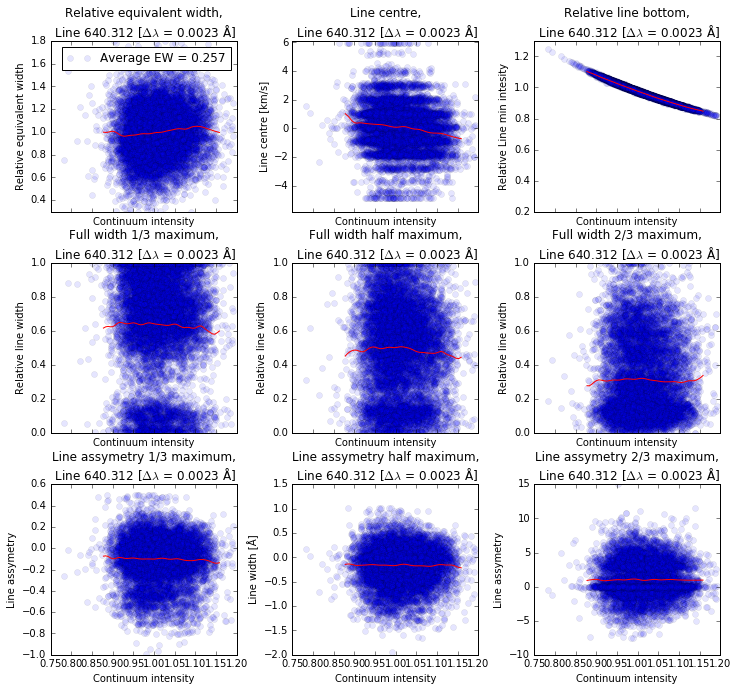

In [419]:
pl.rcParams["figure.figsize"] = (12,11)
vis.spline_linemap(mesCNq,CNq)

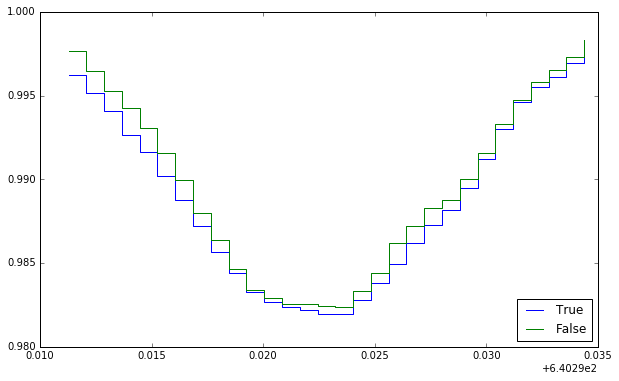

In [420]:
pl.rcParams["figure.figsize"] = (10,6)
CNqSplits = bn.binspec(s6405_t5p,mesCNq[:,cont], (mesCNq[:,fw23]/CNq.width > 0.2) )
pl.step(s6405_t5p.lmbd[CNq.idx],CNqSplits.binned[0,CNq.idx],label="True")
pl.step(s6405_t5p.lmbd[CNq.idx],CNqSplits.binned[1,CNq.idx],label="False")
pl.legend(loc="lower right")